In [1]:
import numpy as np
from scipy.stats.stats import pearsonr
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.time import Time

from os.path import exists 
from GPbaseband1 import *

#Using latex rendering:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

/opt/python/2.7.10/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
class DispersionMeasure(u.Quantity):
    dispersion_delay_constant = 4149. * u.s * u.MHz**2 * u.cm**3 / u.pc
    _default_unit = u.pc / u.cm**3

    def __new__(cls, dm, unit=None, dtype=None, copy=True):
        if unit is None:
            unit = getattr(dm, 'unit', cls._default_unit)
        self = super(DispersionMeasure, cls).__new__(cls, dm, unit,
                                                     dtype=dtype, copy=copy)
        if not self.unit.is_equivalent(cls._default_unit):
            raise u.UnitsError("Dispersion measures should have units of "
                               "pc/cm^3")
        return self

    def __quantity_subclass__(self, unit):
        if unit.is_equivalent(self._default_unit):
            return DispersionMeasure, True
        else:
            return super(DispersionMeasure,
                         self).__quantity_subclass__(unit)[0], False

    def __call__(self, f, fref, kind='complex'):
        d = self.dispersion_delay_constant * self
        if kind == 'delay':
            return d * (1./f**2 - 1./fref**2)
        else:
            dang = (d * f * (1./fref-1./f)**2) * u.cycle
            if kind == 'phase':
                return dang
            elif kind == 'complex':
                return np.exp(dang.to(u.rad).value * 1j)

        raise ValueError("kind not one of 'delay', 'phase', or 'complex'")



GP_data class and initial values:

In [3]:
size = 2 ** 22
sample_rate = 32 * u.MHz
dt1 = 1/sample_rate
#
thread_ids = [0, 4, 1, 5, 2, 6, 3, 7, 8, 12, 9, 13, 10, 14, 11, 15]
fedge = 1610.49 * u.MHz + ((np.linspace(0,15,16) % 8) // 2) * 32. * u.MHz
fref = fedge.mean() + sample_rate / 4
nchan = 512
# October DM from JB ephemeris (1e-2 is by eye correction)
dm = (56.7957 + 1e-2) * u.pc / u.cm**3

dm = DispersionMeasure(dm)

def get_SN(outputsumfreq):
    noise_std = np.std(outputsumfreq[:1000]) 
    noise_mean = np.mean(outputsumfreq[:1000])
    sigs_noise = (outputsumfreq-noise_mean)/noise_std
    return sigs_noise

def overlap_freq_specs(fs1,fs2):
    f, axarr = plt.subplots(8, 1)
    frequency_interval = nchan+1
    for i in range(8):
        freqs = np.linspace(i*16+16.0/(nchan+1)*2,i*16+16.0/(nchan+1)*30,nchan/8*7)+1610.49 #actual frequencies 
        #axarr[i].plot(freqs,gp1.freq_spec[i*frequency_interval:(i+1)*frequency_interval])
        #axarr[i].plot(freqs,gp2.freq_spec[i*frequency_interval:(i+1)*frequency_interval])
        axarr[i].plot(freqs,fs1[i])
        axarr[i].plot(freqs,fs2[i])
        axarr[i].axhline(0,color = 'black')
        axarr[i].axhline(fs1[i].mean(),color = 'blue')
        axarr[i].axhline(fs2[i].mean(),color = 'green')
        if i==4:
            axarr[i].set_ylabel('Intensity of peak with that frequency') 
    axarr[i].set_xlabel('frequency (MHz)')
    axarr[0].set_title('Frequency spectrum of giant pulses (c ={},dt = {}s) with phases {} {} at\n '.format(round(c[0],4),dts,round(float(phase1),4),round(float(phase2),4))+gp1.t_gp.value+' and '+gp2.t_gp.value)
    plt.show()

class GP_data(object):
    def __init__(self,fn,t_gp):
        self.t_gp = t_gp
        fh = mark5b.open(fn, mode='rs', nchan=16,
                        sample_rate=sample_rate, thread_ids=thread_ids, ref_mjd=57000)
        offset_gp = ((t_gp - fh.tell(unit='time')).to(u.s).value *
                     fh.frames_per_second * fh.samples_per_frame)
        fh.seek(int(offset_gp) - size // 2)
        self.d_dispersed = fh.read(size)

        #start_time = time.time()
        #print start_time
        self.process_data()
        #print time.time()-start_time
        self.process_output()

    def process_data(self):
        ft = np.fft.rfft(self.d_dispersed, axis=0)
        # Second half of IFs have Fedge at top, need to subtract frequencies, 
        # and not conjugate coherent phases
        f = fedge + np.fft.rfftfreq(self.d_dispersed.shape[0], dt1)[:, np.newaxis]
        f[:,8:] = fedge[8:] - np.fft.rfftfreq(self.d_dispersed.shape[0], dt1)[:, np.newaxis]
        ft[:,:8] *= dm(f[:,:8], fref, kind='complex').conj()
        ft[:,8:] *= dm(f[:,8:], fref, kind='complex')
        self.d_dedispersed = np.fft.irfft(ft, axis=0)

        # Channelize the data
        self.dchan = np.fft.rfft(self.d_dedispersed.reshape(-1, 2*nchan, 16), axis=1) #axis 1 means across the nchan+1 values in each time bin
        # Horribly inelegant, but works for now. 
        # Channels are not in order, and polarizations are separate
        self.dR = np.concatenate((self.dchan[:,::-1,8], self.dchan[...,0], self.dchan[:,::-1,10], self.dchan[...,2], self.dchan[:,::-1,12], self.dchan[...,4], self.dchan[:,::-1,14], self.dchan[...,6]), axis=1)
        self.dL = np.concatenate((self.dchan[:,::-1,9], self.dchan[...,1], self.dchan[:,::-1,11], self.dchan[...,3], self.dchan[:,::-1,13], self.dchan[...,5], self.dchan[:,::-1,15], self.dchan[...,7]), axis=1)
        self.output = (abs(self.dR)**2 + abs(self.dL)**2).T

    def process_output(self):
        self.outputsumfreq = self.output.sum(0) #dedispersed
        #computes signal to noise after summing all the frequencies
        self.sigs_noise = get_SN(self.outputsumfreq)
        self.S_N = max(self.sigs_noise)
        print self.S_N

        self.peak_time = np.argmax(self.sigs_noise)
        
        self.background_freq = self.output[:,self.peak_time-300:self.peak_time-100].mean(1)
        
        self.sigma_noise = np.std(self.background_freq)

        self.output_pulse = self.output[:,self.peak_time]

        self.freq_spec = self.output_pulse-self.background_freq

    def plot_figs(self):
        #plots the frequency spectrum: 
        plt.close('all')

        #plots the dynamic spectrum de-dispersed: 
        plt.figure()
        #plt.imshow(self.output, aspect='auto',extent=(-8*8192/1000,8*8192/1000,1610.49+16*8,1610.49))
        plt.imshow(self.output, aspect='auto')
        plt.xlabel('time (ms)')
        plt.ylabel('frequency (MHz)')
        plt.title('dynamic spectrum of de-dispersed giant pulse around '+self.t_gp.value)
        plt.colorbar()

        #plots the signal vs noise of de-dispersed
        plt.figure() 
        plt.plot(self.sigs_noise)
        plt.xlabel('time ($16 \mu s$)')
        plt.ylabel('S/N')
        plt.title('Signal to noise of de-dispersed pulse around '+self.t_gp.value)

        plt.show()
        #plots the signal vs noise of dispersed - looks like noise, so won't plot

    def plot_fs(self):
        '''plots the frequency spectrum as a single plot'''
        f, axarr = plt.subplots(2, 1)
        axarr[0].plot(self.freq_spec) 
        axarr[0].set_xlabel('frequency')
        axarr[0].set_ylabel('Auto correlated frequency spectrum')
        axarr[1].plot(self.freq_spec)
        axarr[1].set_ylabel('Peak frequency spectrum')
        axarr[1].set_xlabel('frequency') 
        plt.show()

Reading text files and creating a Giant pulse object:

In [4]:
i = 6
j = 7
'''
gp_average = np.load('./figures/correlation_coeff/giant_pulses_average{}chan.npz'.format(nchan))
with np.load('./figures/correlation_coeff/giant_pulses{}chan.npz'.format(nchan)) as npzfile:
    freq_values = npzfile['freq_values']
    time_values = npzfile['time_values']
    noise_sigma_values = npzfile['noise_sigma_values']
'''
def correlate(i,j):
    '''My function to find the correlation coefficient, to test np.corrcoef. results are the same.'''
    fs1 = freq_values[i]/gp_average-1
    fs2 = freq_values[j]/gp_average-1
    numerator = np.fft.rfft(fs1)*np.fft.rfft(fs2)
    #denominator = 

text_name = 'all7_sorted1.txt'
with open(text_name, 'r') as f:
    text = f.read()
    text_lines = text.split('\n')

strings1 = text_lines[i-1].split()
strings2 = text_lines[j-1].split()
if text_name[0] == 'a': # get information from a all__.txt file
    scan_no1 = strings1[0]
    scan_no2 = strings2[0]
    t1 = strings1[1]
    t2 = strings2[1]
    phase1 = strings1[3]
    phase2 = strings2[3]
fn1 = '/home/xzxu/trails/data/ef/ek036a_ef_no00{}.m5a'.format(scan_no1)
fn2 = '/home/xzxu/trails/data/ef/ek036a_ef_no00{}.m5a'.format(scan_no2)
print 'changed'
t_gp1 = Time(t1)
t_gp2 = Time(t2)

dt = t_gp2-t_gp1
dts = round(dt.sec,4)

#gp1=GP_data(fn1,t_gp1)

changed


In [5]:
gp6=GP_data(fn1,t_gp1)

#gp6.plot_figs()
#gp1.output.shape

55.612036885


In [11]:
#gp258.plot_figs()
#gp6.output.shape
bg6=gp6.background_freq
#bg=gp258.background_freq
#bg258=gp258.output[:,gp258.peak_time-300:gp258.peak_time-100].mean(1)

NameError: name 'gp258' is not defined

In [18]:
def process_freq_spec(gp1,draw=1):
    '''function takes a continuous frequency spectrum and cuts it into 8 bands, divide by the giant pulse mean, and normalize it by itself gp1=freq_spec[i]. function also plots the frequency spectrum'''
    gp1_8=np.zeros(shape=(0,425))
    gp1_8_divided=np.zeros(shape=(0,425))
    for j in range(8):gp1_8=np.append(gp1_8,np.array([gp1[j*513+40:j*513+465]]),0)
    gp1_8_divided=gp1_8/gpab #Dividing by giant pulse average
    for i in range(8):gp1_8[i]=gp1_8[i]/gp1_8[i].mean()-1.
    if draw==1:
        f,axarr=plt.subplots(8,1,figsize=(10,15))

        for i in range(8):axarr[i].plot(gp1_8[i])
        axarr[0].set_title('Frequency spectrum of background noise')
    return gp1_8_divided , gp1_8

def transform_to_timelag(fgp):
    tgp=np.zeros(shape=(0,213))
    for i in range(8):tgp=np.append(tgp,np.array([np.fft.rfft(fgp[i])]),0)

    f,axarr=plt.subplots(8,1,figsize=(10,15))
    for i in range(8):axarr[i].plot(np.linspace(0,16,213),abs(tgp[i]))
    axarr[0].set_title('Time lag spectrum of background noise')
    axarr[7].set_xlabel('Time lag(\mu s)')
    return tgp


In [23]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [10]:
def find_std(tgp):
    stda=np.std(abs(tgp),axis=0)
    figure(figsize=(10,6))
    plot(np.linspace(0,16,213),stda)
    title('Standard deviation as a function of time lag')

In [7]:
gpab=np.load('./figures/correlation_coeff/gpa_smoothed.npy')


Use code below for plotting anything with 8 bands 

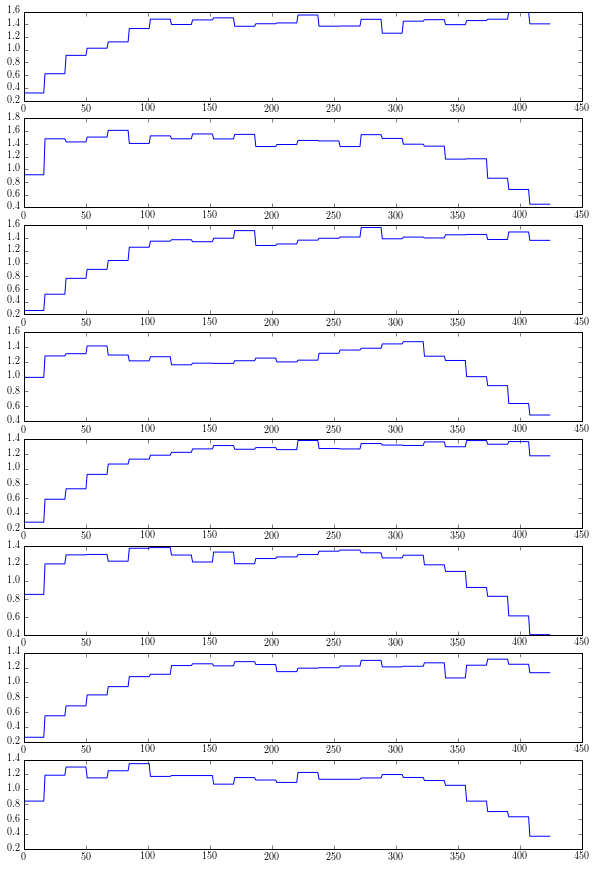

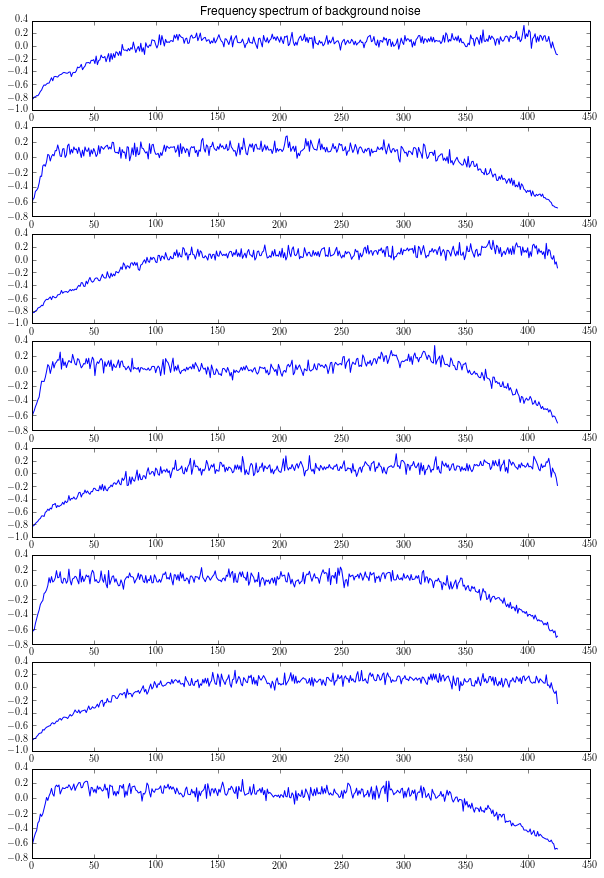

In [24]:
f,axarr=plt.subplots(8,1,figsize=(10,15))
for i in range(8):axarr[i].plot(gpab[i])
fbg6d,fbg6=process_freq_spec(bg6)
# f,axarr=plt.subplots(8,1,figsize=(10,15))
# for i in range(8):axarr[i].plot(fbg6[i])

In [22]:
plt.show()


Frequency spectrum of background noise after dividing by giant pulse average binned  

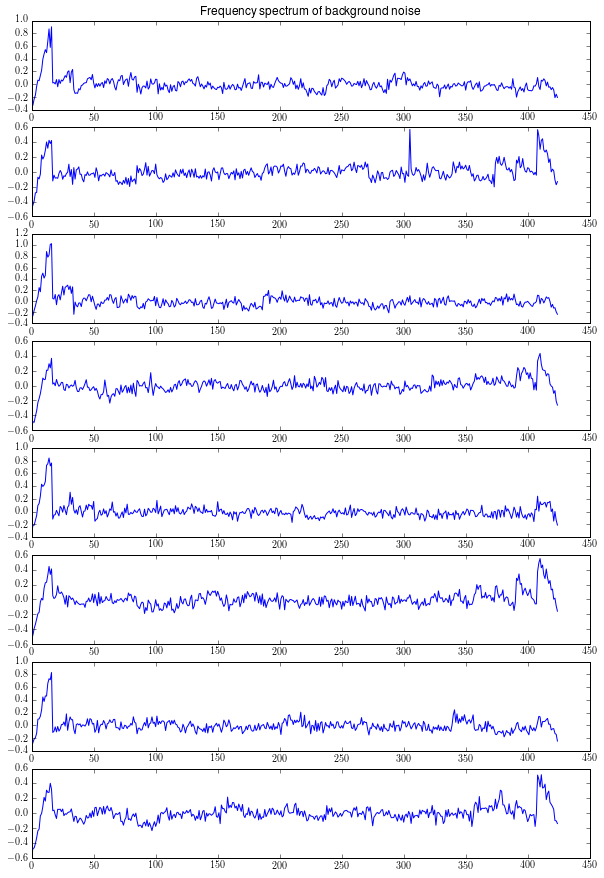

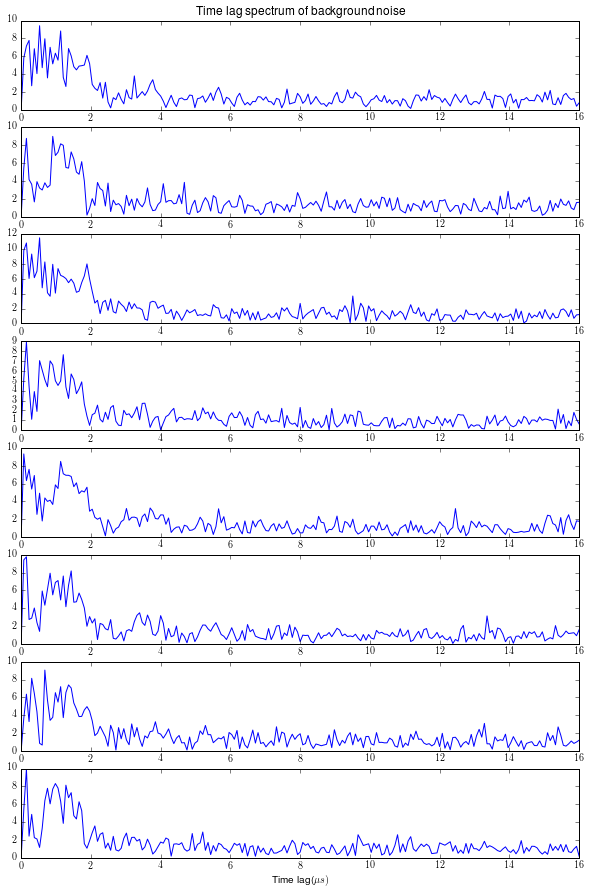

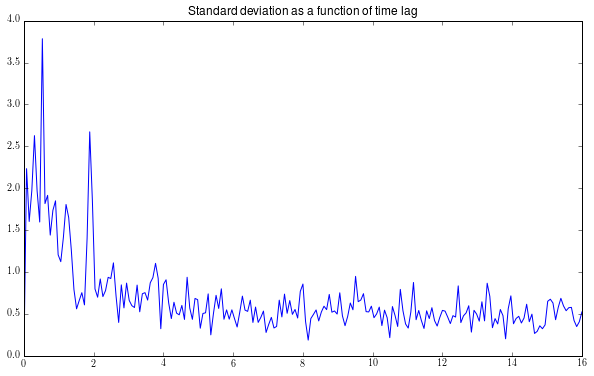

In [58]:
'''
#Get a background smoothed curve:
bga = fbg.reshape(8,25,17).mean(2)
bga = np.repeat(bga,17,axis=1)

f,axarr=plt.subplots(8,1,figsize=(10,15))
for i in range(8):
    axarr[i].plot(bga[i])
    #xarr[i].plot(fbg[i])
'''

fbg6=process_freq_spec(bg6)
tbg6=transform_to_timelag(fbg6)
tbgstd=find_std(tbg6) 

In [45]:
#f,axarr=plt.subplots(8,1,figsize=(10,15))
#for i in range(8):axarr[i].plot(gpab[i])

In [28]:
gpab.shape


(8, 425)